# Experiment II
This is a experiment of the project *The Relation Between Date Implemented of Policies and The Spreading of COVID-19*. This is all the source code used in the second experiment.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

# Prepare Data

In [3]:
df = pd.read_csv("../dataset/confirmed_no_recov.csv")

In [4]:
df 

,country_region,province_state,date,confirmed,deaths
0,Afghanistan,-,2020-01-22,0,0
1,Albania,-,2020-01-22,0,0
2,Algeria,-,2020-01-22,0,0
3,Andorra,-,2020-01-22,0,0
4,Angola,-,2020-01-22,0,0
5,Antigua and Barbuda,-,2020-01-22,0,0
6,Argentina,-,2020-01-22,0,0
7,Armenia,-,2020-01-22,0,0
8,Australia,Australian Capital Territory,2020-01-22,0,0
9,Australia,New South Wales,2020-01-22,0,0


In [5]:
#filter out ship
df = df[df.country_region != 'Diamond Princess']
df = df[df.country_region != 'MS Zaandam']
df = df.fillna("-")

## filter not report recovered and comfirmed < 100 

In [6]:
df = df[df.confirmed >= 100]

In [7]:
df_filtered = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20178 entries, 69 to 43607
Data columns (total 5 columns):
country_region    20178 non-null object
province_state    20178 non-null object
date              20178 non-null object
confirmed         20178 non-null int64
deaths            20178 non-null int64
dtypes: int64(2), object(3)
memory usage: 945.8+ KB


## group by week

In [8]:
df.insert(2, "week", pd.to_datetime(df.date).dt.week)
df_before_week = df.copy()

In [9]:
df = df.drop('date', axis=1)

In [10]:
df = df.groupby(['country_region', 'province_state', 'week']).agg(max).reset_index()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 5 columns):
country_region    3004 non-null object
province_state    3004 non-null object
week              3004 non-null int64
confirmed         3004 non-null int64
deaths            3004 non-null int64
dtypes: int64(3), object(2)
memory usage: 117.4+ KB


## Fix some weird 

In [12]:
df.loc[df.province_state == 'Prince Edward Island', 'deaths'] = 0

In [13]:
df.loc[df.country_region == 'Taiwan*', 'country_region'] = 'Taiwan' 

# Feature engineer

## add how many week from start for each country

In [14]:
wfs = df.groupby(['country_region','province_state']).agg({'week':min}).rename(columns={'week':'started_week'}).reset_index()

In [15]:
wfs = wfs.merge(df[['country_region','province_state','week']])

In [16]:
df.insert(2, 'weeks', wfs.week - wfs.started_week)

## add death rate

In [17]:
df = df.assign(death_rate = df.deaths/df.confirmed)

## add diff

In [18]:
ad = df.groupby(['country_region','province_state']).diff()[['confirmed','deaths','death_rate']]\
            .rename(columns={'confirmed':'confirmed_diff', 'deaths':'deaths_diff', 'death_rate':'death_rate_diff'})\
            .fillna(0)
df = df.assign(confirmed_diff = ad.confirmed_diff)
df = df.assign(deaths_diff = ad.deaths_diff)
df = df.assign(death_rate_diff = ad.death_rate_diff)

## add peak

In [19]:
ad = df.groupby(['country_region','province_state']).max()[['confirmed_diff','deaths_diff']].reset_index()\
        .rename(columns={'confirmed_diff':'peak_confirmed', 'deaths_diff':'peak_deaths'})

In [20]:
df = pd.merge(df,ad, on=['country_region', 'province_state'])

## add avg

In [21]:
av = df.groupby(['country_region','province_state']).mean()[['confirmed_diff','deaths_diff']].reset_index()\
        .rename(columns={'confirmed_diff':'avg_confirmed', 'deaths_diff':'avg_deaths'})

In [22]:
df = pd.merge(df,av, on=['country_region', 'province_state'])

## add after peak

In [23]:
aap = df[df.confirmed_diff == df.peak_confirmed][['country_region','province_state','week']].rename(columns={'week': 'peak_week'})
aap = aap.groupby(['country_region','province_state']).min().reset_index()

In [24]:
df = pd.merge(df,aap, on=['country_region', 'province_state'])

In [25]:
df = df.assign(after_peak = df.week-df.peak_week)

## add thisweek/maxweek

In [26]:
df = df.assign(ctm = df.confirmed_diff/df.peak_confirmed)
df = df.assign(dtm = df.deaths_diff/df.peak_deaths)
df = df.fillna(0).rename(columns={"ctm":"c_thisweek/maxweek","dtm":"d_thisweek/maxweek"})

## add thisweek/avg

In [27]:
df = df.assign(ctm = df.confirmed_diff/df.avg_confirmed)
df = df.assign(dtm = df.deaths_diff/df.avg_deaths)
df = df.fillna(0).rename(columns={"ctm":"c_thisweek/avg","dtm":"d_thisweek/avg"})
df.head()

,country_region,province_state,weeks,week,confirmed,deaths,death_rate,confirmed_diff,deaths_diff,death_rate_diff,peak_confirmed,peak_deaths,avg_confirmed,avg_deaths,peak_week,after_peak,c_thisweek/maxweek,d_thisweek/maxweek,c_thisweek/avg,d_thisweek/avg
0,Afghanistan,-,0,13,120,4,0.033333,0.0,0.0,0.000000,5137.0,100.0,1838.363636,32.090909,23,-10,0.000000,0.00,0.000000,0.000000
1,Afghanistan,-,1,14,349,7,0.020057,229.0,3.0,-0.013276,5137.0,100.0,1838.363636,32.090909,23,-9,0.044579,0.03,0.124567,0.093484
2,Afghanistan,-,2,15,607,18,0.029654,258.0,11.0,0.009597,5137.0,100.0,1838.363636,32.090909,23,-8,0.050224,0.11,0.140342,0.342776
3,Afghanistan,-,3,16,996,33,0.033133,389.0,15.0,0.003478,5137.0,100.0,1838.363636,32.090909,23,-7,0.075725,0.15,0.211601,0.467422
4,Afghanistan,-,4,17,1531,50,0.032658,535.0,17.0,-0.000474,5137.0,100.0,1838.363636,32.090909,23,-6,0.104146,0.17,0.291020,0.529745


## add expeak

In [28]:
ep = df[(df.week < df.peak_week - 1) | (df.week > df.peak_week + 1)].groupby(['country_region', 'province_state']).max()['confirmed_diff']\
        .reset_index().rename(columns={'confirmed_diff':'expeak_confirmed'})

In [29]:
df = pd.merge(df,ep, on=['country_region', 'province_state'])

## add after expeak

In [30]:
aaep = df[df.confirmed_diff == df.expeak_confirmed][['country_region','province_state','week']].rename(columns={'week': 'expeak_week'})
aaep = aaep.groupby(['country_region','province_state']).min().reset_index()

In [31]:
df = pd.merge(df,aaep, on=['country_region', 'province_state'])

In [32]:
df = df.assign(after_expeak = df.week-df.expeak_week)

## add propotional to last week

In [33]:
df = df.assign(confirmed_diff_pct = df.confirmed / (df.confirmed - df.confirmed_diff))
df = df.assign(deaths_diff_pct = df.deaths / (df.deaths - df.deaths_diff)) 

# K-means Clustering 

## select features

In [34]:
df_before_clustering = df.copy()
df = df[['country_region', 'province_state', 'weeks', 'week','after_peak', 'c_thisweek/maxweek','c_thisweek/avg']]
df.head()

,country_region,province_state,weeks,week,after_peak,c_thisweek/maxweek,c_thisweek/avg
0,Afghanistan,-,0,13,-10,0.000000,0.000000
1,Afghanistan,-,1,14,-9,0.044579,0.124567
2,Afghanistan,-,2,15,-8,0.050224,0.140342
3,Afghanistan,-,3,16,-7,0.075725,0.211601
4,Afghanistan,-,4,17,-6,0.104146,0.291020


## minmax scalar

In [35]:
mms = MinMaxScaler()
df = df.set_index(['country_region','province_state', 'week'])
df_scaled = pd.DataFrame(mms.fit_transform(df),columns=df.columns,index=df.index)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## find K cluster using sillhoutte 

In [36]:
def sillhoutte(n=15, n_average=5):
    w_all = [0]*(n-2)
    for i in range(n_average):
        w = []
        for k in np.arange(2,n,1):
            model = KMeans(n_clusters=k, n_jobs=-1).fit(df_scaled)
            preds = model.predict(df_scaled)
            silhouette = silhouette_score(df_scaled, preds)
            w.append(silhouette)
        for i, num in enumerate(w_all):
            w_all[i] = w_all[i]+w[i]
    w_all = [x/n_average for x in w_all]        
    plt.plot(np.arange(2,n,1),w_all)
    plt.ylabel('Silhouette score', fontsize=15)
    plt.xlabel('Number of clusters', fontsize=15)
    plt.grid()
    plt.savefig('silhouettle.png')

In [37]:
#sillhoutte(10,10)

## plot centroid using optimized K cluster

In [38]:
k = 8

In [39]:
#random state = 42
cls = KMeans(n_clusters=k, n_jobs=-1, random_state=42)
cls.fit(df_scaled)
df.insert(0,'cluster',cls.predict(df_scaled))
df_scaled.insert(0,'cluster',cls.predict(df_scaled))

In [40]:
import joblib
filename = 'cluster.sav'

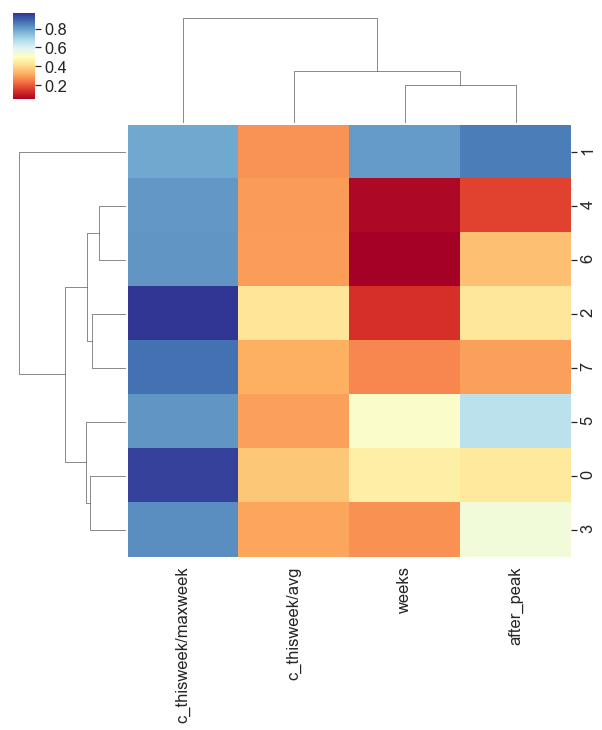

In [41]:
centroid = pd.DataFrame(cls.cluster_centers_, columns=df_scaled.drop(columns=['cluster']).columns)
import seaborn as sns
sns.set(font_scale=1.5)
sns.clustermap(centroid, cmap='RdYlBu')

# Interpretion from K-means result

In [42]:
df = df.reset_index()
df_scaled = df_scaled.reset_index()

In [43]:
def show_pivot(df):
    cluster_count = df.drop(['country_region'],axis=1).groupby(['cluster','week']).mean()
    cluster_count.insert(1, 'count', df.drop('country_region',axis=1).groupby(['cluster','week']).size())
    cluster_count = cluster_count.reset_index()
    cluster_pivot = cluster_count.pivot(index='cluster', columns='week', values='count').fillna(0).astype(int)
    return cluster_pivot

In [44]:
show_pivot(df)

week,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
cluster,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,4,5,11,15,21,44,72,90,91,88
1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,18,20,21,25,26,34
2,0,2,18,18,4,1,1,1,12,38,69,66,44,28,13,10,16,12,15,10
3,0,0,0,1,16,20,21,22,18,5,3,17,43,68,78,67,46,21,13,18
4,0,0,2,3,3,6,5,19,50,65,66,58,27,11,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,3,18,20,21,22,21,15,31,57,82,104,105
6,3,16,2,2,4,4,15,31,55,57,42,27,22,16,25,20,13,11,4,0
7,0,0,0,0,0,0,2,3,4,6,7,26,59,74,73,59,29,15,3,1


## central tendency group by cluster

In [45]:
cluster = df.drop(['country_region','week'],axis=1).groupby('cluster').mean()
cluster.insert(0,'count',df.drop('country_region',axis=1).groupby('cluster').size())
cluster

,count,weeks,after_peak,c_thisweek/maxweek,c_thisweek/avg
cluster,,,,,
0,441,8.768707,0.206349,0.745529,1.723030
1,147,15.367347,13.503401,0.012725,0.075528
2,378,2.730159,0.058201,0.835368,2.987574
3,477,5.408805,3.580713,0.201920,0.597573
4,315,1.298413,-8.466667,0.142300,0.327438
5,499,9.935872,7.282565,0.165899,0.445579
6,369,0.983740,-2.634146,0.161521,0.416008
7,361,5.168975,-4.182825,0.427976,0.893912


In [46]:
cluster = df_scaled.drop(['country_region','week'],axis=1).groupby('cluster').mean()
cluster.insert(0,'count',df_scaled.drop('country_region',axis=1).groupby('cluster').size())
cluster

,count,weeks,after_peak,c_thisweek/maxweek,c_thisweek/avg
cluster,,,,,
0,441,0.461511,0.443948,0.945738,0.369959
1,147,0.808808,0.859481,0.789478,0.287478
2,378,0.143693,0.439319,0.964895,0.433267
3,477,0.284674,0.549397,0.829821,0.313614
4,315,0.068338,0.172917,0.817108,0.300090
5,499,0.522941,0.665080,0.822140,0.306005
6,369,0.051776,0.355183,0.821207,0.304524
7,361,0.272051,0.306787,0.878024,0.328450


## query using country

In [47]:
df_merge = df_before_clustering.copy()
df_merge.insert(1,'cluster',df.cluster)

In [48]:
country = 'Thailand'
state = '-'
df_merge[(df_merge.country_region == country) & (df_merge.province_state == state)]

,country_region,cluster,province_state,weeks,week,confirmed,deaths,death_rate,confirmed_diff,deaths_diff,...,after_peak,c_thisweek/maxweek,d_thisweek/maxweek,c_thisweek/avg,d_thisweek/avg,expeak_confirmed,expeak_week,after_expeak,confirmed_diff_pct,deaths_diff_pct
2185,Thailand,6,-,0,11,114,1,0.008772,0.0,0.0,...,-2,0.000000,0.0000,0.000000,0.000000,382.0,15,-4,1.000000,1.000000
2186,Thailand,2,-,1,12,599,1,0.001669,485.0,0.0,...,-1,0.614702,0.0000,2.103069,0.000000,382.0,15,-3,5.254386,1.000000
2187,Thailand,2,-,2,13,1388,7,0.005043,789.0,6.0,...,0,1.000000,0.3750,3.421281,1.368421,382.0,15,-2,2.317195,7.000000
2188,Thailand,2,-,3,14,2169,23,0.010604,781.0,16.0,...,1,0.989861,1.0000,3.386591,3.649123,382.0,15,-1,1.562680,3.285714
2189,Thailand,3,-,4,15,2551,38,0.014896,382.0,15.0,...,2,0.484157,0.9375,1.656438,3.421053,382.0,15,0,1.176118,1.652174
2190,Thailand,3,-,5,16,2765,47,0.016998,214.0,9.0,...,3,0.271229,0.5625,0.927952,2.052632,382.0,15,1,1.083889,1.236842
2191,Thailand,3,-,6,17,2922,51,0.017454,157.0,4.0,...,4,0.198986,0.2500,0.680787,0.912281,382.0,15,2,1.056781,1.085106
2192,Thailand,3,-,7,18,2969,54,0.018188,47.0,3.0,...,5,0.059569,0.1875,0.203803,0.684211,382.0,15,3,1.016085,1.058824
2193,Thailand,5,-,8,19,3009,56,0.018611,40.0,2.0,...,6,0.050697,0.1250,0.173449,0.456140,382.0,15,4,1.013473,1.037037
2194,Thailand,5,-,9,20,3028,56,0.018494,19.0,0.0,...,7,0.024081,0.0000,0.082388,0.000000,382.0,15,5,1.006314,1.000000


In [49]:
cluster = df_merge.copy()

# Merge with measure

## preprocess measure data

In [50]:
measure = pd.read_csv("../dataset/measures.csv",index_col=0)

In [51]:
measure.columns = [x.lower() for x in measure.columns]

In [52]:
measure.country = measure.country.replace({'Brunei Darussalam':'Brunei', 'Congo':'Congo (Brazzaville)',
               'Congo DR': 'Congo (Kinshasa)', 'Czech Republic':'Czechia',
               'Korea DPR':'Korea, North', 'Korea Republic of':'Korea, South',
               'Moldova Republic Of':'Moldova', 'North Macedonia Republic Of':'North Macedonia',
               'Russian Federation':'Russia', 'United States of America':'US',
                'Viet Nam':'Vietnam',"CÃ´te d'Ivoire":"Cote d'Ivoire"})

In [53]:
measure.date_implemented = pd.to_datetime(measure.date_implemented)

In [54]:
cluster[cluster.country_region == "Australia"]

,country_region,cluster,province_state,weeks,week,confirmed,deaths,death_rate,confirmed_diff,deaths_diff,...,after_peak,c_thisweek/maxweek,d_thisweek/maxweek,c_thisweek/avg,d_thisweek/avg,expeak_confirmed,expeak_week,after_expeak,confirmed_diff_pct,deaths_diff_pct
70,Australia,6,Australian Capital Territory,0,15,103,2,0.019417,0.0,0.0,...,-2,0.000000,0.000000,0.000000,0.000000,1.0,19,-4,1.000000,1.000000
71,Australia,6,Australian Capital Territory,1,16,103,3,0.029126,0.0,1.0,...,-1,0.000000,1.000000,0.000000,9.000000,1.0,19,-3,1.000000,1.500000
72,Australia,2,Australian Capital Territory,2,17,106,3,0.028302,3.0,0.0,...,0,1.000000,0.000000,5.400000,0.000000,1.0,19,-2,1.029126,1.000000
73,Australia,3,Australian Capital Territory,3,18,106,3,0.028302,0.0,0.0,...,1,0.000000,0.000000,0.000000,0.000000,1.0,19,-1,1.000000,1.000000
74,Australia,3,Australian Capital Territory,4,19,107,3,0.028037,1.0,0.0,...,2,0.333333,0.000000,1.800000,0.000000,1.0,19,0,1.009434,1.000000
75,Australia,3,Australian Capital Territory,5,20,107,3,0.028037,0.0,0.0,...,3,0.000000,0.000000,0.000000,0.000000,1.0,19,1,1.000000,1.000000
76,Australia,3,Australian Capital Territory,6,21,107,3,0.028037,0.0,0.0,...,4,0.000000,0.000000,0.000000,0.000000,1.0,19,2,1.000000,1.000000
77,Australia,3,Australian Capital Territory,7,22,107,3,0.028037,0.0,0.0,...,5,0.000000,0.000000,0.000000,0.000000,1.0,19,3,1.000000,1.000000
78,Australia,5,Australian Capital Territory,8,23,108,3,0.027778,1.0,0.0,...,6,0.333333,0.000000,1.800000,0.000000,1.0,19,4,1.009346,1.000000
79,Australia,6,New South Wales,0,11,134,2,0.014925,0.0,0.0,...,-2,0.000000,0.000000,0.000000,0.000000,277.0,15,-4,1.000000,1.000000


In [55]:
measure = measure.assign(week = measure.date_implemented.dt.week)
measure = measure.rename(columns={'level':'province_state'})

In [56]:
measure = measure.rename(columns={'country':'country_region'})
measure = measure[(measure.type == 'Introduction / extension of measures')]
measure.head()

,country_region,measure,type,province_state,region,category,date_implemented,entry_date,week
0,Australia,awareness campaigns,Introduction / extension of measures,-,Pacific,Public health measures,2020-03-17,2020-03-21 00:00:00,12
1,Australia,awareness campaigns,Introduction / extension of measures,NSW,Pacific,Public health measures,2020-04-08,2020-04-09 00:00:00,15
2,Australia,awareness campaigns,Introduction / extension of measures,NT,Pacific,Public health measures,2020-03-26,2020-03-27 00:00:00,13
3,Australia,awareness campaigns,Introduction / extension of measures,WA,Pacific,Public health measures,2020-04-27,2020-04-27 00:00:00,18
4,Australia,border closure,Introduction / extension of measures,-,Pacific,Movement restrictions,2020-03-20,2020-03-21 00:00:00,12


## merge with cluster data 

In [57]:
df = pd.merge(cluster,measure,on=['country_region', 'province_state','week'], how='outer')

## Shift 2 week 

In [58]:
measure_shift = measure.drop('week', axis=1)

In [59]:
#add day
shifted_day = 14
measure_shift.date_implemented = measure_shift.date_implemented + pd.DateOffset(days=shifted_day)

In [60]:
measure_shift = measure_shift.assign(week = measure_shift.date_implemented.dt.week)

In [61]:
df_shift = pd.merge(cluster,measure_shift,on=['country_region','province_state', 'week'], how='outer')
df_shifted = df_shift.copy()

In [62]:
df_shifted

,country_region,cluster,province_state,weeks,week,confirmed,deaths,death_rate,confirmed_diff,deaths_diff,...,expeak_week,after_expeak,confirmed_diff_pct,deaths_diff_pct,measure,type,region,category,date_implemented,entry_date
0,Afghanistan,4.0,-,0.0,13,120.0,4.0,0.033333,0.0,0.0,...,21.0,-8.0,1.000000,1.000000,limit public gatherings,Introduction / extension of measures,Asia,Social distancing,2020-03-26,2020-03-14 00:00:00
1,Afghanistan,4.0,-,0.0,13,120.0,4.0,0.033333,0.0,0.0,...,21.0,-8.0,1.000000,1.000000,schools closure,Introduction / extension of measures,Asia,Social distancing,2020-03-29,2020-04-07 00:00:00
2,Afghanistan,4.0,-,1.0,14,349.0,7.0,0.020057,229.0,3.0,...,21.0,-7.0,2.908333,1.750000,state of emergency declared,Introduction / extension of measures,Asia,Governance and socio-economic measures,2020-04-03,2020-04-07 00:00:00
3,Afghanistan,4.0,-,2.0,15,607.0,18.0,0.029654,258.0,11.0,...,21.0,-6.0,1.739255,2.571429,NaN,NaN,NaN,NaN,NaT,NaN
4,Afghanistan,4.0,-,3.0,16,996.0,33.0,0.033133,389.0,15.0,...,21.0,-5.0,1.640857,1.833333,changes in prison-related policies,Introduction / extension of measures,Asia,Social distancing,2020-04-14,2020-05-11 00:00:00
5,Afghanistan,7.0,-,4.0,17,1531.0,50.0,0.032658,535.0,17.0,...,21.0,-4.0,1.537149,1.515152,NaN,NaN,NaN,NaN,NaT,NaN
6,Afghanistan,7.0,-,5.0,18,2704.0,85.0,0.031435,1173.0,35.0,...,21.0,-3.0,1.766166,1.700000,NaN,NaN,NaN,NaN,NaT,NaN
7,Afghanistan,7.0,-,6.0,19,4402.0,120.0,0.027260,1698.0,35.0,...,21.0,-2.0,1.627959,1.411765,NaN,NaN,NaN,NaN,NaT,NaN
8,Afghanistan,7.0,-,7.0,20,6664.0,169.0,0.025360,2262.0,49.0,...,21.0,-1.0,1.513857,1.408333,NaN,NaN,NaN,NaN,NaT,NaN
9,Afghanistan,0.0,-,8.0,21,10582.0,218.0,0.020601,3918.0,49.0,...,21.0,0.0,1.587935,1.289941,NaN,NaN,NaN,NaN,NaT,NaN


# Find correlation

In [63]:
def corr_each_measure(df):
    measures_corr = {}
    measures_corr['features'] = list(df[df.measure == list(set(df.measure))[0]].groupby(['measure','country_region','province_state']).mean().dropna().corr().index)
    for measure in list(set(df.measure)):
        wfs = df[df.measure == measure].groupby(['measure','country_region','province_state']).mean().dropna().corr()['weeks']
        measures_corr[measure] = list(wfs)
    return pd.DataFrame(measures_corr).set_index('features')

In [64]:
def filter_and_plot(df, threshold):
    temp = df.applymap(lambda x: x if x>threshold or x <(-1)*threshold else 0)
    sns.clustermap(temp.drop('weeks'), cmap='RdYlBu')

In [65]:
def corr_cluster(df_shifted, target_cols, target_cluster, threshold):
    df_temp = df_shifted[(df_shifted.cluster.isin(target_cluster)) & (df_shifted.measure != 'humanitarian exemptions')]
    df_temp = df_temp[target_cols]
    df_t = df_temp.copy()
    df_temp = corr_each_measure(df_temp)
    temp = df_t.groupby('measure').size().sort_values(ascending=False).reset_index().rename(columns={0:'count'})
    col = list(temp[(temp['count'] >= temp['count'].max()*0.25) & (temp['count'] > 10)].measure)
    print(temp)
    print(temp.sum())
    filter_and_plot(df_temp[col], threshold)
    return df_temp[col]

                                              measure  count
0                                            lockdown     39
1                                   economic measures     37
2       requirement to wear protective gear in public     32
3              strengthening the public health system     30
4               other public health measures enforced     27
5           closure of businesses and public services     24
6                                     schools closure     23
7                                      border closure     22
8                             limit public gatherings     21
9                   isolation and quarantine policies     20
10                        surveillance and monitoring     19
11                   international flights suspension     17
12                                     testing policy     16
13                       domestic travel restrictions     15
14                        state of emergency declared     14
15                 chang

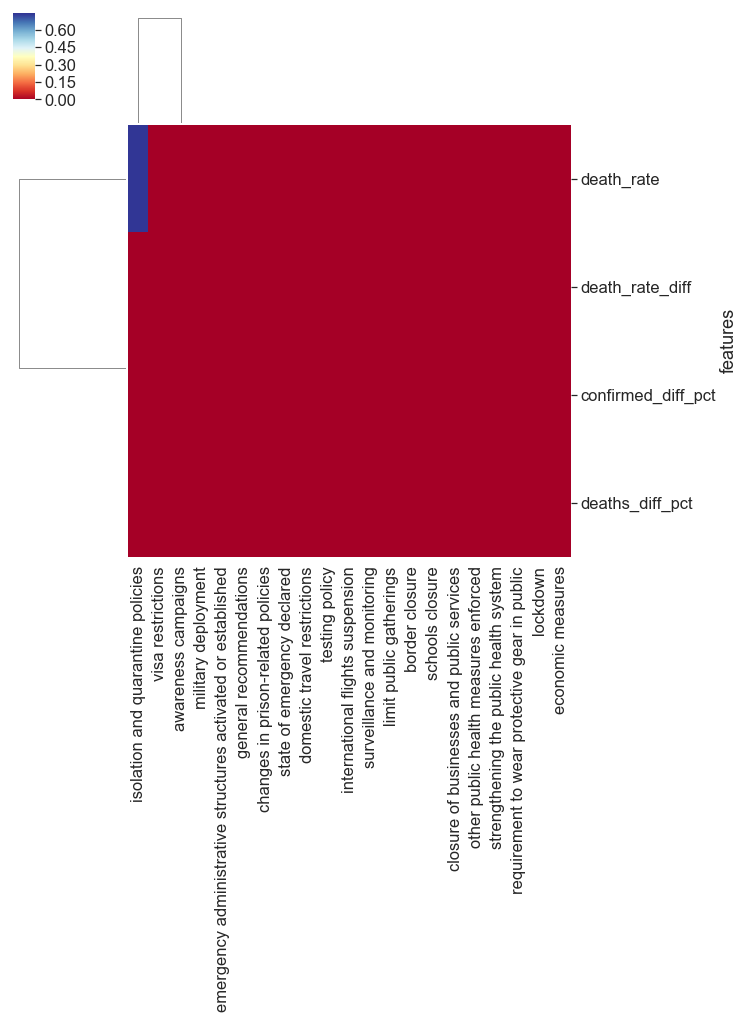

In [66]:
#find correlation and visual as a heatmap with threshold
base_cols = ['country_region', 'province_state', 'weeks','measure']
target_cols = base_cols + ['death_rate','confirmed_diff_pct', 'deaths_diff_pct', 'death_rate_diff']
target_cluster =  [1,6,7] #6, 1,7 before peak 2,4 peak
threshold = 0.6


df_corr = corr_cluster(df_shifted, target_cols, target_cluster, threshold)

## sort by value 

In [67]:
threshold = 0.5
m = df_corr[(df_corr > threshold) | (df_corr < threshold*-1) ].melt()
m[m.value < 1].sort_values(by='value')

,variable,value
39,border closure,0.501895
31,schools closure,0.509048
59,international flights suspension,0.555696
46,isolation and quarantine policies,0.743247


## plot value 

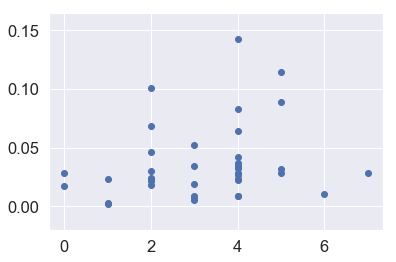

In [68]:
def plot_corr(df_plot, measure, feature):
    plt.scatter(df_plot[df_plot.measure.str.match('^'+measure+'.*') == True]['weeks'], df_plot[df_plot.measure.str.match('^'+measure+'.*') == True][feature])
df_plot = df_shifted[(df_shifted.cluster.isin(target_cluster)) & (df_shifted.measure != 'humanitarian exemptions')]

#Input measure(start with) and feature you wanna plot
plot_corr(df_plot, measure='lock', feature = 'death_rate')